# Assignment 1: Sentiment Polarity 

In [ ]:
import os
import numpy as np
from numpy.linalg import norm
import time
import matplotlib.pyplot as plt
import random

## Part 1: Parsing the dataset

In [ ]:
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-06-04 21:50:32--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘review_polarity.tar.gz’ not modified on server. Omitting download.



In [ ]:
files = !tar xvzf review_polarity.tar.gz
files = list(files)

In [ ]:
X_raw = []
y_labels = []
 
# negative files
for file in files[:1000]:
  with open(file, 'r') as f: 
    filecontent = f.read()
    filecontent = filecontent.replace('\n', '')
    X_raw.append(filecontent)

# positive files
for file in files[1000:2000]:
  with open(file, 'r') as f:
    filecontent = f.read()
    filecontent = filecontent.replace('\n', '')
    X_raw.append(filecontent)

# labels
y = np.asarray((([-1] * 1000 + [1] * 1000)))

In [ ]:
ordered_vocab = []

for review in X_raw:
  review = review.split(' ')
  ordered_vocab.extend(review)


vocab = sorted(set(ordered_vocab))
            
print(len(ordered_vocab), len(vocab))

1496584 50921


## Part 2: Feature Encoding

In [ ]:
lut = dict()

for i, word in enumerate(vocab):
    lut[word] = i

# initialising BOW with only zeros...
X = np.zeros((len(X_raw), len(vocab)))

for i, doc in enumerate(X_raw):
    for word in doc.split():
        X[i, lut[word]] = 1

In [ ]:
X_train = np.concatenate((X[:800, :], X[1000:1800, :]))
X_test = np.concatenate((X[800:1000, :], X[1800:2000, :]))

y_train = np.concatenate((y[:800], y[1000:1800]))
y_test = np.concatenate((y[800:1000], y[1800:2000]))

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

## Part 3: Learning Framework

In [ ]:
class Model:
    def __init__(self, learning_rate, reguliser_dampening):
        self.learning_rate = learning_rate # γ - gamma
        self.reguliser_dampening = reguliser_dampening # λ - lambda

    def _hinge_loss(self, X_train, y_train):
        hinge_sigma = 0
        for i, arr in enumerate(X_train):
            hinge_sigma += max(0, 1 - (np.multiply(y_train[i], np.vdot(self.omega, arr))))
        hinge_loss = (self.reguliser_dampening/2) * norm(self.omega)**2 + hinge_sigma
        return hinge_loss
    
    def _gradient(self, X_train, y_train):
        gd_sigma = np.zeros(len(X_train[0]))
        for i, arr in enumerate(X_train):
            if np.multiply(y_train[i], np.vdot(self.omega, arr)) < 1:
                gd_sigma -= (y_train[i] * arr)
        gradient = self.reguliser_dampening * self.omega + gd_sigma
        self.omega = self.omega - self.learning_rate * gradient
        return self.omega
    
    def fit(self, X_train, y_train):
        X_train = np.c_[np.ones((len(X_train),1)), X_train] # pseudo input
        self.omega = np.random.normal(0, 1, size=X_train.shape[1]) # randomized omega with normal (Gaussian) distribution

        # calculate first hinge loss with randomized omega
        hinge_loss = self._hinge_loss(X_train, y_train)

        # calculate new omega with gradient descent
        self.omega = self._gradient(X_train, y_train)

        # update hinge loss
        hinge_loss = self._hinge_loss(X_train, y_train)

        # find best hinge loss with certain criteria
        best_hinge_loss = hinge_loss
        counter = 0
        for _ in range(500):
            self.omega = self._gradient(X_train, y_train)
            hinge_loss = self._hinge_loss(X_train, y_train)
            if 5 > hinge_loss - best_hinge_loss < 0:
                counter +=1 
            if 5 > hinge_loss - best_hinge_loss < 0 and counter == 20:
                hinge_loss = best_hinge_loss
                break
            if hinge_loss < best_hinge_loss:
                best_hinge_loss = hinge_loss

    # predict values with best omega (found through best hingeloss)
    def predict(self, X_train, y_train):
        X_train = np.c_[np.ones((len(X_train),1)), X_train]
        predicted = []
        for array in X_train:
            predicted.append(np.sign(np.matmul(array, self.omega)))
        return predicted
    
    def score(self, X_test, y_test):
        predicted = self.predict(X_test, y_test)
        return np.sum(predicted == y_test)/len(y_test)*100

    def plot(self):
        plt.figure(figsize=(20, 3))
        plt.plot(self.omega[1:])
        plt.xlabel("Value")
        plt.xlabel("Weights")
        plt.show()
    
    def weights_occurences(self, docs, vocab):
        idx = np.argsort(np.abs(self.omega[1:]))
        print("                Word   Weight  Occurences")
        for i in idx[-20:]:  
            print("%20s   %.3f\t%i " % (vocab[i], self.omega[i+1], np.sum([vocab[i] in d for d in docs])))

In [ ]:
model = Model(learning_rate=0.1, reguliser_dampening=0.001)

In [ ]:
model.fit(X_train=X_train, y_train=y_train)

In [ ]:
predicted = model.predict(X_train=X_train, y_train=y_train)

In [ ]:
model.score(X_test=X_test, y_test=y_test)

61.0

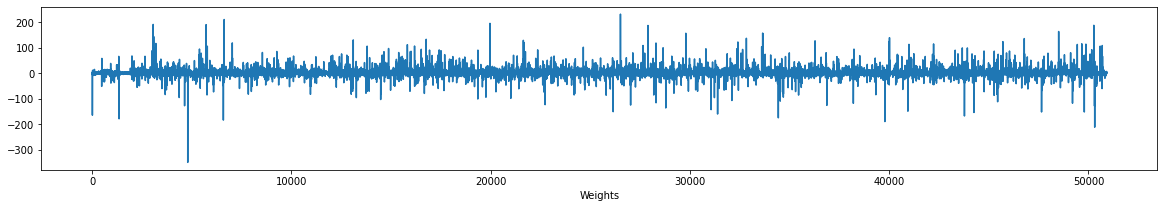

In [ ]:
model.plot()

In [ ]:
model.weights_occurences(docs=X_raw, vocab=vocab)

                Word   Weight  Occurences
            supposed   -154.505	321 
                most   156.424	1439 
             perfect   157.121	403 
             nothing   -160.586	594 
                very   163.297	1552 
                   !   -165.083	663 
              stupid   -168.251	227 
                plot   -175.473	1002 
                   ?   -179.343	1228 
              boring   -184.327	229 
                many   186.957	796 
               world   187.648	643 
              script   -190.189	632 
                best   190.259	867 
                also   191.047	1071 
               great   195.266	805 
                both   210.316	683 
               worst   -212.237	238 
                life   231.460	895 
                 bad   -350.353	825 


## Part 4: Exploring hyperparameters

In [ ]:
best_hyperparameters = None
parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [ ]:
start = time.time()
number_of_iterations = 10
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for _ in range(number_of_iterations):
    lr = parameter_distribution['learning_rate'][random.randint(0, 9)]
    reg_damp = parameter_distribution['reguliser_dampening'][random.randint(0, 9)]
    model = Model(learning_rate=lr, reguliser_dampening=reg_damp)
    model.fit(X_train, y_train)
    model_accuracy = model.score(X_train, y_train)

    if best_hyperparameters is None or best_hyperparameters[2] < model_accuracy:
        best_hyperparameters = (lr, reg_damp, model_accuracy)
    print("%.5f\t\t%.5f\t\t%.1f%%" % (lr, reg_damp, model_accuracy))

end = time.time()
print("Time taken for grid search in seconds:", round(end-start, ndigits=5))

Learning rate:	Reg.dampening:	Training set accuracy:
0.00311		0.00977		64.6%
3.00000		0.00010		93.9%
0.00031		0.09655		59.6%
0.30353		0.00099		95.6%
0.00010		0.00010		53.4%
0.00977		0.00977		63.7%
0.30353		3.00000		50.0%
0.95425		0.95425		50.0%
0.00977		3.00000		52.6%
0.09655		0.00099		93.1%
Time taken for grid search in seconds: 406.57599


In [ ]:
best_combination = best_hyperparameters[0], best_hyperparameters[1]
print("Best combination of parameters:")
print("Learning rate", round(best_combination[0], ndigits=5))
print("Reguliser dampening", round(best_combination[1], ndigits=5))

Best combination of parameters:
Learning rate 0.30353
Reguliser dampening 0.00099


### Best Model

In [ ]:
best_model = Model(learning_rate=best_combination[0], reguliser_dampening=best_combination[1])
best_model.fit(X_train=X_train, y_train=y_train)

In [ ]:
best_model_accuracy = best_model.score(X_test=X_test, y_test=y_test)
print("Best model's accuracy:", best_model_accuracy)

Best model's accuracy: 85.0


## Implementation of Work

After parsing the dataset, the negative and positive raw documents were extracted and the labels array was created in correlation with the documents. A very simple tokenization was implemented (using whitespaces) to create the unique list of words. The encoding was fastly executed through the use of a dictionary and afterwards, the data was splitted into a training and a test set, using the 80/20 method. The model was implemented as a class, avoiding DRY as much as possible by using different methods. Following that, the best hyperparameters from the gridsearch sample for the best model were explored and used to output the best possible results for the training data. 

## Qualitative Analysis

The initial hyperparameters (learning = 0.1, reguliser_dampening = 0.001) resulted in a score of 61% whereas the best model from the grid search sample had triple the learning rate but the same regularization. This suggests that although a higher learning rate may result in an unstable hinge loss development, it may, in some instances, produce better results. This drawback may have been compensated by the counter (set on 20) assigned in the stopping  criteria. Initially, I was expecting that the counter will significantly increase the time taken to fit the data however that was not the case.
The weights for the words with the strongest influence convey some easily understandable results. For example, 'stupid', 'boring', 'worst' and 'bad' were negatively connotated and 'perfect', 'best' and 'great' were positively connotated. However, other results are not that obvious. Furthermore, the results show that the tokenization process could have been definitely improved, although this was not the main focus of the assignment.
Throughout the work, arrays were generally used to facilitate indexing and mathematical operations. Implementing the model into a class and methods was a great option to prevent repeating code. The use of dictionaries (and arrays) has also greatly decreased the time taken to encode the data. 

## General comments

I think that this assignment has served really well to give us a better understanding on how models work under the hood. It was definitely a tough assignment however it was very fruitful. The mathematical framework was the most difficult to comprehend but easier to implement. Initially focusing on understanding the framework was a waste of time given that without implementing it, this would almost never be possible.